In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op


import external4

from contextlib import contextmanager

## Model

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],''
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 6.7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7.27, 9, 7]},
        
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

nBins = len(model.expected_actualdata(model.config.suggested_init()))

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [2]:
with open('SRee_SRmm_Srem.json') as serialized:
# with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()
obs = workspace.data(model, include_auxdata=False)
nBins = len(model.expected_actualdata(model.config.suggested_init()))

## Sampling with external module

In [3]:
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
}

prior_dict = external4.prepare_priors(model, unconstr_dict)

In [7]:
prepared_model = external4.prepare_model(model=model, observations=obs, precision=0.10, priors=prior_dict)
print(external4.get_target(model))

[ 4  0  1  2  3 14 15 16  5  6  7  8  9 10 11 12 13]


In [5]:
post_data, post_pred, prior_pred = external4.sampling(prepared_model, 500)

/Users/malinhorstmann/Documents/pyhf_pymc/PredictiveChecks/external4.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.array(norm_mu).size != 0:
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Gammas, Normals, Unconstrained, main]


## Plotting

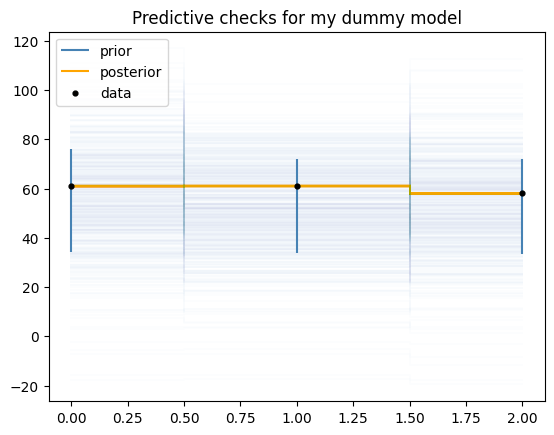

In [6]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for my dummy model')

plt.show()

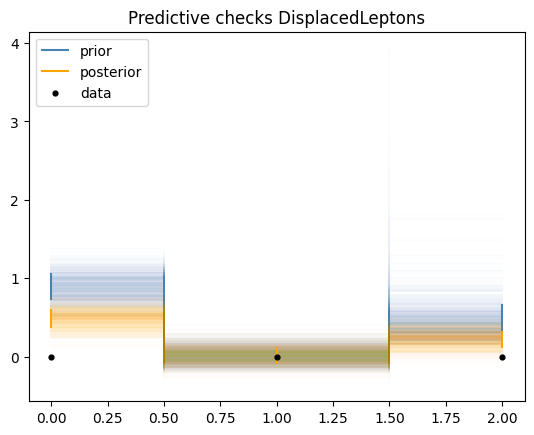

In [9]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks DisplacedLeptons')

plt.show()

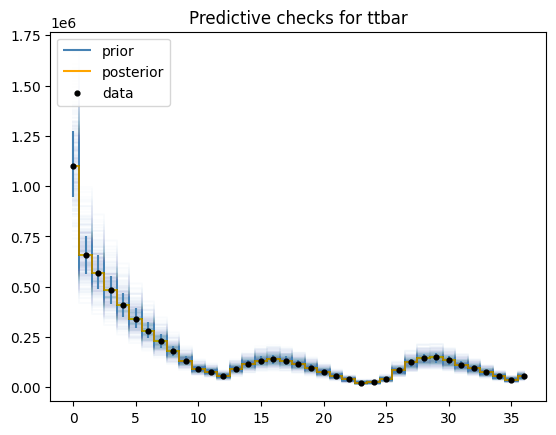

In [13]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for ttbar')

plt.show()